In [1]:
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool, Process
import scipy.signal as sig

label_font = {'fontname':'Arial', 'size':'11', 'color':'black', 'weight':'normal',
          'verticalalignment':'bottom'} 
title_font = {'fontname':'sans-serif', 'size':'16', 'color':'red', 'weight':'bold'}
legend_font = {'family':'sans-serif', 'size':'10', 'style':'normal'} 


In [2]:
def genWhiteNoise(mu, sigma, size):
    """
    Generate samples of normally distributed white noise
    
    :param mu: Mean of the white noise
    :type mu: float
    :param sigma: Standard deviation of the noise 
    :type sigma: float
    :param size: Number of samples to generate
    :type size: integer
    :return: Array of normally distributed data
    :rtype: numpy array
    """
    samples = np.random.normal(mu, sigma, size)
    return samples


def genTimeVals(fs, size, timeUncertainty):
    """
    Generate time samples with jitter
    
    :param fs: Sampling frequency (in Hz)
    :type fs: float
    :param size: Number of samples to generate
    :type size: integer
    :return: Array of time samples
    :rtype: numpy array
    """
    uncertainties =  np.random.normal(0, timeUncertainty, size = size)
    timeVals = np.asarray(range(int(size))) / fs + uncertainties 
    return timeVals


def genSignal(amplitude, frequency, times):
    """
    Generate sinusoidal data

    :param amplitude: Amplitude
    :type amplitude: float
    :param frequency: Frequency of sine wave
    :type frequency: float
    :param time: Times to sample sine wave at
    :type time: numpy array
    :return: Array of sampled sine wave
    :rtype: numpy array
    """
    return amplitude*np.sin(2*np.pi*frequency*times)


def checkPowerOf10(value):
    """
    Check if a number is a power of 10
    
    :param value: Number to check
    :type value: float
    :return: Boolean if number is a power of 10
    :rtype: Boolean
    """
    value = int(value)
    while (value >= 10 and value % 10 == 0):
        value /= 10
    return value == 1

def convADCCount(dynamicRange, offset, bitDepth, data):
    stepSize = dynamicRange / 2**bitDepth
    # The below makes it so that an offset of 0 centers the data at 0
    lowVal = offset - dynamicRange / 2.
    highVal = offset + dynamicRange / 2.
    ADCVals = [int((x - lowVal)/stepSize) for x in data]
    ADCVals = [x if (x > 0 and x < 2**bitDepth) else (0 if x < 0 else 2**bitDepth - 1) for x in ADCVals]
    return np.asarray(ADCVals)



In [ ]:
sigFreq = 4e8
numSamps = 2**20

sampFreq = 1.E9
sigAmp = 0.001

muNoise = 0
sigNoise = 0.1

binWidth = sampFreq/numSamps
timeUncertainty = .1 * 1/sampFreq

timeValsPerfect = genTimeVals(sampFreq, numSamps, 0)
sigValsPerfect = genSignal(sigAmp, sigFreq, timeValsPerfect)

timeVals = genTimeVals(sampFreq, numSamps, timeUncertainty)
sigVals = genSignal(sigAmp, sigFreq, timeVals)

noiseVals = genWhiteNoise(muNoise, sigNoise, numSamps)

dataVals = noiseVals + sigVals
dataValsPerfect = noiseVals + sigValsPerfect

# Plot the data
if 0:
    #%matplotlib widget
    plt.close('all')
    #Scatter plot comparing jittered signal to perfectly sampled signal
    if 1:
        #I changed to plot sampled data against *perfect* time vals. System maps imperfect samples to grid it thinks is correct
        plt.figure()
        plt.scatter(timeValsPerfect*10**6, dataVals, label = 'jitter')
        plt.scatter(timeValsPerfect*10**6, dataValsPerfect, label = 'no jitter')

        # The weird symbol is the unicode character for mu
        plt.xlabel(u'Time (\u03BCs)', labelpad = 15, **label_font)
        plt.ylabel('Amplitude (V)', **label_font)
        plt.show()
        plt.legend()
        plt.title('Compare signal sampled with jitter to one without')

    if 1:
        plt.figure()
        plt.plot(timeValsPerfect*10**6, dataVals)

        # The weird symbol is the unicode character for mu
        plt.xlabel(u'Time (\u03BCs)', labelpad = 15, **label_font)
        plt.ylabel('Amplitude (V)', **label_font)
        plt.show()



In [ ]:
# dynamic range, offset, bit depth, data
dynamicRange = 1
offset = 0
bitDepth = 8
ADCVals = convADCCount(dynamicRange, offset, bitDepth, dataVals)
ADCValsVolts = ADCVals*1.0*dynamicRange/2**bitDepth + offset - dynamicRange/2

# Plot the data
if 0:
    plt.close('all')
    if 1:
        #sampled ADC counts vs time
        plt.figure()
        plt.plot(timeValsPerfect*10**6, ADCVals)

        # The weird symbol is the unicode character for mu
        plt.xlabel(u'Time (\u03BCs)', labelpad = 15, **label_font)
        plt.ylabel('Amplitude (ADC Counts)', **label_font)
        plt.show()
    if 1:
        # sampled voltage vs time
        plt.figure()
        plt.plot(timeValsPerfect*10**6, ADCValsVolts)

        # The weird symbol is the unicode character for mu
        plt.xlabel(u'Time (\u03BCs)', labelpad = 15, **label_font)
        plt.ylabel('Amplitude (V)', **label_font)
        plt.show()


In [ ]:
#%matplotlib widget
fftLen = len(ADCVals)
freqData = (np.abs(np.fft.fft(ADCValsVolts, fftLen))[0:int(fftLen/2)+1])**2
freqData = freqData/fftLen**2
freqData = np.asarray([2*x if (counter > 0 and counter < int(fftLen/2)) else x for counter, x in enumerate(freqData)])

freqStep = sampFreq/fftLen
frequencies = np.asarray(range(0, int(fftLen/2)+1))*freqStep

freqDataLog = 10*np.log10(freqData*1000/50)

maxFreq = frequencies[np.argmax(freqDataLog[1:]) + 1]/10**6
print('MAX FREQUENCY AT ' + str(round(maxFreq, 6)) + ' MHz')
print('MAX BIN AT ' + str(np.argmax(freqDataLog[1:]) + 1))

if 1:
    plt.figure()
    plt.plot((frequencies/10.**6)[1:], freqDataLog[1:])
    plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
    plt.ylabel(r'Power (dBm)', **label_font)
    plt.show()


In [ ]:
# Now do many averages of the data - model the frequency uncertainty as a change on the sampling frequency
plt.close('all')

sigFreq = 1.2345E8
numSamps = 2**24

sampFreq = 1.E9
sigAmp = 0.01

muNoise = 0
sigNoise = 0.1

numAvg = 100
#freqUncertainty = 1E3

dynamicRange = 1
offset = 0
bitDepth = 8

 
freqUncertainties = [1E0, 1E1, 1E2, 1E3, 1E4, 1E5, 1E6, 1E7]
maxAmps = []

for anUncertainty in freqUncertainties:
    freqDataTotal = np.zeros(int(numSamps/2)+1)
    print('ON UNCERTAINTY ' + str(anUncertainty))
    for x in range(numAvg):
        if x and x % 10 == 9:
            print('ON ITERATION '+ str(x + 1))
        timeVals = genTimeVals(sampFreq + np.random.normal(0, anUncertainty), numSamps, 0)
        sigVals = genSignal(sigAmp, sigFreq, timeVals)
        noiseVals = genWhiteNoise(muNoise, sigNoise, numSamps)
        dataVals = noiseVals + sigVals
        ADCVals = convADCCount(dynamicRange, offset, bitDepth, dataVals)
        ADCValsVolts = ADCVals*1.0*dynamicRange/2**bitDepth + offset - dynamicRange/2
        freqData = (np.abs(np.fft.fft(ADCValsVolts, numSamps))[0:int(numSamps/2)+1])**2
        freqData = freqData/numSamps**2
        freqData = np.asarray([2*x if (counter > 0 and counter < int(fftLen/2)) else x for counter, x in enumerate(freqData)])
        freqDataTotal += freqData


    freqStep = sampFreq/numSamps
    frequencies = np.asarray(range(0, int(numSamps/2)+1))*freqStep
    freqDataLog = 10*np.log10(freqDataTotal*1000/50/numAvg)
    maxFreq = frequencies[np.argmax(freqDataLog[1:]) + 1]/10**6

    print('MAX FREQUENCY AT ' + str(round(maxFreq, 6)) + ' MHz')
    print('MAX BIN AT ' + str(np.argmax(freqDataLog[1:]) + 1))
    maxAmplitude = 10*np.log10(10**(max(freqDataLog[1:])/10.) - np.mean(10**(freqDataLog[1:]/10.)))
    print('MAX AMPLITUDE ' + str(round(maxAmplitude, 3)) + ' dBm ' )
    maxAmps.append(maxAmplitude)
    if 1:
        plt.figure()
        plt.plot((frequencies/10.**6)[1:], freqDataLog[1:])
        plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
        plt.ylabel(r'Power (dBm)', **label_font)
        plt.show() 

if 1:
    plt.figure()
    #plt.plot((frequencies/10.**6)[1:], freqDataLog[1:])
    #plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
    #plt.ylabel(r'Power (dBm)', **label_font)
    #plt.show()
    
    powSig = 10*np.log10(sigAmp**2/50/2*1000)
    plt.plot(np.asarray(freqUncertainties)/sampFreq, maxAmps, 'ro', label = 'TOTAL POWER: ' + str(round(powSig, 3)) + ' dBm \n SAMPLING RATE: ' + str(round(sampFreq/10**9, 2)) + str('GHz'))
    plt.gca().set_xscale('log')
    plt.xlabel('Fractional Sampling Rate Uncertainty', labelpad = 15, **label_font)
    plt.ylabel(r'Power (dBm)', **label_font)
    plt.title('RESOLUTION: ' + str(round(sampFreq/numSamps, 2)) + ' Hz ', **title_font)
    plt.legend(prop = legend_font)
    plt.show()              
    


In [15]:
np.load('hist_valonRb_1week.npy', allow_pickle=True)
valonHist = np.load('hist_valonRb_1week.npy', allow_pickle=True)
valonFreqDev = valonHist[1]
valonFreqDevMidpoints = (valonFreqDev[1:] + valonFreqDev[:-1]) / 2
valonNormCounts = valonHist[0]/valonHist[0].sum()

#plt.hist(np.random.choice(valonFreqDevMidpoints, 1000000, p = valonNormCounts), bins = 50)

sampFreq = 600e6
anUncertainty = 1
jitteredFreq =  float((anUncertainty * sampFreq * np.random.choice(valonFreqDevMidpoints, 1, p = valonNormCounts)))
print(jitteredFreq)


600000000.0510887


In [13]:
jitteredFreq = sampFreq + np.random.normal(0, anUncertainty)
jitteredFreq

599999981.5956306

In [17]:
#JL

# Normal

plt.close('all')

sigFreq = 298e6
numSamps = 2**24

sampFreq = 600e6
sigAmp = 0.001

powSigLin = sigAmp**2/50/2
powSig = 10*np.log10(powSigLin * 1000)

sigPowerTheory = sigAmp**2/50 / 2 #theoritical power. Off by a factor of 2?
sigPowerTheorydBm = 10*np.log10(sigPowerTheory * 1000)

binWidth = sampFreq/numSamps

muNoise = 0
sigNoise = 0.1

numAvg = 40
#freqUncertainty = 1E3

dynamicRange = 1
offset = 0
bitDepth = 8

#freqUncertaintiesFrac = np.array([0.01, 1, 100])
freqUncertaintiesFrac = np.array([1])
freqUncertainties = freqUncertaintiesFrac * binWidth
maxAmps = []
qList = []
snrList = []

np.load('hist_valonRb_1week.npy', allow_pickle=True)
valonHist = np.load('hist_valonRb_1week.npy', allow_pickle=True)
valonFreqDev = valonHist[1]
valonFreqDevMidpoints = (valonFreqDev[1:] + valonFreqDev[:-1]) / 2
valonNormCounts = valonHist[0]/valonHist[0].sum()

np.random.choice(valonFreqDevMidpoints, 1, p = valonNormCounts)

def worker(numAvg):
    #if x and x % 10 == 9:
    #    print('ON ITERATION '+ str(x + 1))

    np.random.seed()
    #jitteredFreq = sampFreq + np.random.uniform(-anUncertainty, anUncertainty)
    #jitteredFreq = sampFreq + np.random.normal(0, anUncertainty)
    jitteredFreq = float(anUncertainty * sampFreq * np.random.choice(valonFreqDevMidpoints, 1, p = valonNormCounts))
    print(jitteredFreq)
    #print('jitterd freq =', jitteredFreq, '   ')


    #Generate ADC sampled time domain voltage data (with ADC artifacts (jitter plus bit depth)
    #timeVals = genTimeVals(sampFreq + np.random.normal(0, anUncertainty), numSamps, 0)
    timeVals = genTimeVals(jitteredFreq, numSamps, 0)

    dataVals = genSignal(sigAmp, sigFreq, timeVals) + genWhiteNoise(muNoise, sigNoise, numSamps)
    ADCVals = convADCCount(dynamicRange, offset, bitDepth, dataVals)
    ADCValsVolts = ADCVals*1.0*dynamicRange/2**bitDepth + offset - dynamicRange/2

    #perform FFT on ADC sampled data and sum 
    freqData = (np.abs(np.fft.fft(ADCValsVolts, numSamps))[0:int(numSamps/2)+1])**2
    freqData = freqData/numSamps**2
    freqData = np.asarray([2*x if (counter > 0 and counter < int(numSamps/2)) else x for counter, x in enumerate(freqData)])
    return(freqData, jitteredFreq)


for i, anUncertainty in enumerate(freqUncertainties):
    freqDataTotal = np.zeros(int(numSamps/2)+1)
    print('################################################################ ') 
    print('UNCERTAINTY = ' + str(round(anUncertainty,3)), 'Hz')
    print('FRACTIONAL UNCERTAINTY (f_uncertianty/f_bin) = ' + str(round(anUncertainty/binWidth, 3)))
    print('################################################################ ') 

    pool = Pool(processes = 40)
    #pool returns a list of tuples of shape (list[numAvgs, lenFFT)], int)
    workerReturn = (pool.map(worker, range(numAvg)))
    
    #unpack worker return
    freqDataAll = np.asarray([x[0] for x in workerReturn])
    randFreqSamp = [x[1] for x in workerReturn] 
    
    #average frequency data, convert to dBm
    freqDataAvg = freqDataAll.mean(axis = 0)
    freqDataLog = 10*np.log10(freqDataAvg*1000/50)
    
    #create array of frequency bins
    frequencies = np.asarray(range(0, int(numSamps/2)+1))*binWidth
    
    #simple peak find
    #maxFreqIdx = np.argmax(freqDataLog[1:])
    

    peaks, _ = sig.find_peaks(freqDataAvg, distance=numSamps)
    maxFreq = frequencies[peaks[0] + 1]
    fwhm = sig.peak_widths(freqDataAvg, peaks, rel_height=0.5)
    #print('fwhm = ', fwhm[0][0], '(bins)')
    #print('fwhm = ', fwhm[0][0] * binWidth, '(Hz)')
    
    Q = maxFreq/(fwhm[0][0] * binWidth)
    #print('Q=', '{:e}'.format(Q))
    


    if i == 0:
        maxFreqBest = maxFreq

    #print('MAX FREQUENCY AT ' + str(round(maxFreq/1e6, 6)) + ' Mhz')
    #print('MAX FREQUENCY ' + str(round(maxFreqBest/1e6 - maxFreq/1e6, 6)) + ' MHz OFF FROM BEST MAX FREQUENCY')
    #print('MAX BIN AT ' + str(np.argmax(freqDataLog[1:]) + 1))
    #print('MAX AMPLITUDE ' + str(round(maxAmplitude, 3)) + ' dBm ' )

    maxAmplitude = 10*np.log10(10**(max(freqDataLog[1:])/10.) - np.mean(10**(freqDataLog[1:]/10.)))
    snr = (max(freqDataLog[1:])) - np.mean((freqDataLog[1:]))

    snrList.append(snr)
    maxAmps.append(maxAmplitude)
    qList.append(Q)

    %matplotlib inline
    if 0:
    #average spectra
        plt.figure()
        plt.plot((frequencies/10.**6)[1:], freqDataLog[1:])
        plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
        plt.ylabel(r'Power (dBm)', **label_font)
        plt.xlim((sigFreq - sigFreq*.5)/1e6, (sigFreq + sigFreq*0.5)/1e6)
        plt.show()
    if 1:
    #average spectra, zoom on injected signal
        plt.figure()
        plt.plot((frequencies/10.**6)[1:], freqDataLog[1:])
        plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
        plt.ylabel(r'Power (dBm)', **label_font)
        plt.xlim((sigFreq - sigFreq*.00001)/1e6, (sigFreq + sigFreq*0.00001)/1e6)
        plt.show()

    if 0:
    #average spectra, linear power
        plt.figure()
        plt.plot((frequencies/10.**6)[1:], freqDataAvg[1:])
        plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
        plt.ylabel(r'Power (watts)', **label_font)
        plt.xlim((sigFreq - sigFreq*.00001)/1e6, (sigFreq + sigFreq*0.00001)/1e6)
        plt.show()

    if 0:
    #time series of frequencies
        plt.figure()
        plt.plot(randFreqSamp)
        plt.title('time series of sampled frequencies')
        plt.xlabel('FFT number')
        plt.ylabel('Sampled frequency (Hz)')
        plt.show()
    
    if 1:
    #hist of frequencies
        plt.hist(randFreqSamp)
        plt.title('Histogram of sampled frequencies')
        plt.xlabel('Sampled frequency (Hz')
        plt.show()
        

    
    


if 1:
    %matplotlib widget
    plt.figure()
    #plt.plot((frequencies/10.**6)[1:], freqDataLog[1:])
    #plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
    #plt.ylabel(r'Power (dBm)', **label_font)
    #plt.show()
    
    
    plt.plot(np.asarray(freqUncertaintiesFrac), maxAmps, 'ro', label = 'TOTAL POWER: ' + str(round(powSig, 3)) + ' dBm \n SAMPLING RATE: ' + str(round(sampFreq/10**9, 2)) + str('GHz'))
    plt.gca().set_xscale('log')
    plt.xlabel('Fractional Sampling Rate Uncertainty', labelpad = 15, **label_font)
    plt.ylabel(r'Power (dBm)', **label_font)
    plt.title('RESOLUTION: ' + str(round(sampFreq/numSamps, 2)) + ' Hz ', **title_font)
    plt.legend(prop = legend_font)
    plt.grid()
    plt.show() 

if 1:
    plt.figure()
    plt.plot(np.asarray(freqUncertaintiesFrac), snrList, 'ro', label = 'TOTAL POWER: ' + str(round(powSig, 3)) + ' dBm \n SAMPLING RATE: ' + str(round(sampFreq/10**9, 2)) + str('GHz'))
    plt.gca().set_xscale('log')
    plt.xlabel('Fractional Sampling Rate Uncertainty', labelpad = 15, **label_font)
    plt.ylabel(r'SNR (dB)', **label_font)
    plt.title('RESOLUTION: ' + str(round(sampFreq/numSamps, 2)) + ' Hz ', **title_font)
    plt.legend(prop = legend_font)
    plt.grid()
    plt.show() 

if 1:
    plt.figure()
    plt.plot(np.asarray(freqUncertaintiesFrac), qList, 'ro', label = 'TOTAL POWER: ' + str(round(powSig, 3)) + ' dBm \n SAMPLING RATE: ' + str(round(sampFreq/10**9, 2)) + str('GHz'))
    plt.gca().set_xscale('log')
    plt.xlabel('Fractional Sampling Rate Uncertainty', labelpad = 15, **label_font)
    plt.ylabel(r'Q', **label_font)
    plt.title('RESOLUTION: ' + str(round(sampFreq/numSamps, 2)) + ' Hz ', **title_font)
    plt.legend(prop = legend_font)
    plt.grid()
    plt.show() 

 
         
    


################################################################ 
UNCERTAINTY = 35.763 Hz
FRACTIONAL UNCERTAINTY (f_uncertianty/f_bin) = 1.0
################################################################ 
21457672139.4065121457671973.457221457672047.2124521457672102.52888521457672047.2124521457672065.65126421457672065.651264
21457671918.14076221457672194.72295

21457671899.701946
21457672139.4065121457672157.84532521457672213.161762
21457672047.21245
21457672157.845325
21457672176.28414


21457672176.2841421457672268.478203
21457672157.84532521457672084.09007621457672120.9677

21457672028.77364
21457672120.967721457671918.140762
21457672120.967721457672139.40651

21457672213.161762
21457672065.65126421457671991.896015

21457672010.334824
21457672213.161762
21457672157.845325


21457672028.7736421457671991.89601521457671991.896015
21457672194.7229521457672176.2841421457672268.47820321457672120.967721457672065.651264















KeyboardInterrupt: 

In [ ]:
%matplotlib widget
plt.figure()
plt.plot(np.asarray(freqUncertaintiesFrac), maxAmps, 'ro', \
    label = 'SIGNAL POWER: ' + str(round(powSig, 3)) + ' dBm\
         \n SAMPLING RATE: ' + str(round(sampFreq/10**9, 2)) + 'GHz\
         \n RESOLUTION: ' + str(round(sampFreq/numSamps, 2)) + ' Hz ' )
plt.gca().set_xscale('log')
plt.xlabel('Fractional Sampling Rate Uncertainty', labelpad = 15, **label_font)
plt.ylabel('Power (dBm)', **label_font)
plt.title('Power', **title_font)
plt.legend(prop = legend_font)
plt.grid()
plt.show() 

if 1:
    plt.figure()
    plt.plot(np.asarray(freqUncertaintiesFrac), snrList, 'ro', \
    label = 'SIGNAL POWER: ' + str(round(powSig, 3)) + ' dBm\
         \n SAMPLING RATE: ' + str(round(sampFreq/10**9, 2)) + 'GHz\
         \n RESOLUTION: ' + str(round(sampFreq/numSamps, 2)) + ' Hz ' )
    plt.gca().set_xscale('log')
    plt.xlabel('Fractional Sampling Rate Uncertainty', labelpad = 15, **label_font)
    plt.ylabel(r'SNR (dB)', **label_font)
    plt.title('SNR: ', **title_font)
    plt.legend(prop = legend_font)
    plt.grid()
    plt.show() 

if 1:
    plt.figure()
    plt.plot(np.asarray(freqUncertaintiesFrac), qList, 'ro', \
    label = 'SIGNAL POWER: ' + str(round(powSig, 3)) + ' dBm\
         \n SAMPLING RATE: ' + str(round(sampFreq/10**9, 2)) + 'GHz\
         \n RESOLUTION: ' + str(round(sampFreq/numSamps, 2)) + ' Hz ' )
    plt.gca().set_xscale('log')
    plt.xlabel('Fractional Sampling Rate Uncertainty', labelpad = 15, **label_font)
    plt.ylabel(r'Q', **label_font)
    plt.title('Q', **title_font)
    plt.legend(prop = legend_font)
    plt.grid()
    plt.show()

################################################################ 
ON UNCERTAINTY 0.0 Hz
ON UNCERTAINTY (f_uncertiany/f_bin)0.0
################################################################ 
fwhm =  1.067790207453072 (bins)
fwhm =  38.187153605928614 (Hz)
Q= 3.232921e+06
MAX FREQUENCY AT 123.456037 Mhz
MAX FREQUENCY 0.0 MHz OFF FROM BEST MAX FREQUENCY
MAX BIN AT 3452080


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


MAX AMPLITUDE -70.279 dBm 


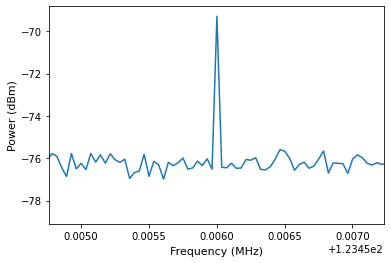

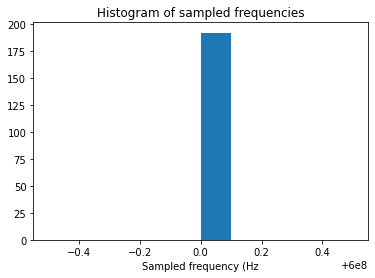

################################################################ 
ON UNCERTAINTY 3.5762786865234375 Hz
ON UNCERTAINTY (f_uncertiany/f_bin)0.1
################################################################ 


Exception ignored in: <function _releaseLock at 0x7fa34f34d040>
Traceback (most recent call last):
  File "/home/dradmin/miniconda3/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


In [3]:
#JL

# Now do many averages of the data - model the frequency uncertainty as a change on the sampling frequency

plt.close('all')

sigFreq = 123.456e6
numSamps = 2**24

sampFreq = 600e6
sigAmp = 0.0001

powSigLin = sigAmp**2/50/2
powSig = 10*np.log10(powSigLin * 1000)

sigPowerTheory = sigAmp**2/50 / 2 #theoritical power. Off by a factor of 2?
sigPowerTheorydBm = 10*np.log10(sigPowerTheory * 1000)

binWidth = sampFreq/numSamps

muNoise = 0
sigNoise = 0.1

numAvg = 48*4
#freqUncertainty = 1E3

dynamicRange = 1
offset = 0
bitDepth = 8

freqUncertaintiesFrac = np.array([0, .1, .3, .5, 1, 2, 3, 10])
#freqUncertaintiesFrac = np.array([0])
freqUncertainties = freqUncertaintiesFrac * binWidth
maxAmps = []
qList = []

def worker(numAvg):
    #if x and x % 10 == 9:
    #    print('ON ITERATION '+ str(x + 1))

    np.random.seed()
    jitteredFreq = sampFreq + np.random.uniform(-anUncertainty, anUncertainty)
    #jitteredFreq = sampFreq + np.random.normal(0, anUncertainty)
    #print('jitterd freq =', jitteredFreq, '   ')


    #Generate ADC sampled time domain voltage data (with ADC artifacts (jitter plus bit depth)
    #timeVals = genTimeVals(sampFreq + np.random.normal(0, anUncertainty), numSamps, 0)
    timeVals = genTimeVals(jitteredFreq, numSamps, 0)

    dataVals = genSignal(sigAmp, sigFreq, timeVals) + genWhiteNoise(muNoise, sigNoise, numSamps)
    ADCVals = convADCCount(dynamicRange, offset, bitDepth, dataVals)
    ADCValsVolts = ADCVals*1.0*dynamicRange/2**bitDepth + offset - dynamicRange/2

    #perform FFT on ADC sampled data and sum 
    freqData = (np.abs(np.fft.fft(ADCValsVolts, numSamps))[0:int(numSamps/2)+1])**2
    freqData = freqData/numSamps**2
    freqData = np.asarray([2*x if (counter > 0 and counter < int(numSamps/2)) else x for counter, x in enumerate(freqData)])
    return(freqData, jitteredFreq)


for i, anUncertainty in enumerate(freqUncertainties):
    freqDataTotal = np.zeros(int(numSamps/2)+1)
    print('################################################################ ') 
    print('ON UNCERTAINTY ' + str(anUncertainty), 'Hz')
    print('ON UNCERTAINTY (f_uncertiany/f_bin)' + str(anUncertainty/binWidth))
    print('################################################################ ') 

    pool = Pool(processes = 48)
    #pool returns a list of tuples of shape (list[numAvgs, lenFFT)], int)
    workerReturn = (pool.map(worker, range(numAvg)))
    
    #unpack worker return
    freqDataAll = np.asarray([x[0] for x in workerReturn])
    randFreqSamp = [x[1] for x in workerReturn] 
    
    #average frequency data, convert to dBm
    freqDataAvg = freqDataAll.mean(axis = 0)
    freqDataLog = 10*np.log10(freqDataAvg*1000/50)
    
    #create array of frequency bins
    frequencies = np.asarray(range(0, int(numSamps/2)+1))*binWidth
    
    #simple peak find
    #maxFreqIdx = np.argmax(freqDataLog[1:])
    

    peaks, _ = sig.find_peaks(freqDataAvg, distance=numSamps)
    maxFreq = frequencies[peaks[0] + 1]
    fwhm = sig.peak_widths(freqDataAvg, peaks, rel_height=0.5)
    print('fwhm = ', fwhm[0][0], '(bins)')
    print('fwhm = ', fwhm[0][0] * binWidth, '(Hz)')
    
    Q = maxFreq/(fwhm[0][0] * binWidth)
    print('Q=', '{:e}'.format(Q))
    


    if i == 0:
        maxFreqBest = maxFreq

    print('MAX FREQUENCY AT ' + str(round(maxFreq/1e6, 6)) + ' Mhz')
    print('MAX FREQUENCY ' + str(round(maxFreqBest/1e6 - maxFreq/1e6, 6)) + ' MHz OFF FROM BEST MAX FREQUENCY')
    print('MAX BIN AT ' + str(np.argmax(freqDataLog[1:]) + 1))
    maxAmplitude = 10*np.log10(10**(max(freqDataLog[1:])/10.) - np.mean(10**(freqDataLog[1:]/10.)))
    print('MAX AMPLITUDE ' + str(round(maxAmplitude, 3)) + ' dBm ' )
    maxAmps.append(maxAmplitude)
    qList.append(Q)

    %matplotlib inline
    if 0:
    #average spectra
        plt.figure()
        plt.plot((frequencies/10.**6)[1:], freqDataLog[1:])
        plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
        plt.ylabel(r'Power (dBm)', **label_font)
        plt.xlim((sigFreq - sigFreq*.5)/1e6, (sigFreq + sigFreq*0.5)/1e6)
        plt.show()
    if 1:
    #average spectra, zoom on injected signal
        plt.figure()
        plt.plot((frequencies/10.**6)[1:], freqDataLog[1:])
        plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
        plt.ylabel(r'Power (dBm)', **label_font)
        plt.xlim((sigFreq - sigFreq*.00001)/1e6, (sigFreq + sigFreq*0.00001)/1e6)
        plt.show()

    if 0:
    #average spectra, linear power
        plt.figure()
        plt.plot((frequencies/10.**6)[1:], freqDataAvg[1:])
        plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
        plt.ylabel(r'Power (watts)', **label_font)
        plt.xlim((sigFreq - sigFreq*.00001)/1e6, (sigFreq + sigFreq*0.00001)/1e6)
        plt.show()

    if 0:
    #time series of frequencies
        plt.figure()
        plt.plot(randFreqSamp)
        plt.title('time series of sampled frequencies')
        plt.xlabel('FFT number')
        plt.ylabel('Sampled frequency (Hz)')
        plt.show()
    
    if 1:
    #hist of frequencies
        plt.hist(randFreqSamp)
        plt.title('Histogram of sampled frequencies')
        plt.xlabel('Sampled frequency (Hz')
        plt.show()
        

    
    


if 1:
    %matplotlib widget
    plt.figure()
    #plt.plot((frequencies/10.**6)[1:], freqDataLog[1:])
    #plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
    #plt.ylabel(r'Power (dBm)', **label_font)
    #plt.show()
    
    
    plt.plot(np.asarray(freqUncertaintiesFrac), maxAmps, 'ro', label = 'TOTAL POWER: ' + str(round(powSig, 3)) + ' dBm \n SAMPLING RATE: ' + str(round(sampFreq/10**9, 2)) + str('GHz'))
    plt.gca().set_xscale('log')
    plt.xlabel('Fractional Sampling Rate Uncertainty', labelpad = 15, **label_font)
    plt.ylabel(r'Power (dBm)', **label_font)
    plt.title('RESOLUTION: ' + str(round(sampFreq/numSamps, 2)) + ' Hz ', **title_font)
    plt.legend(prop = legend_font)
    plt.grid()
    plt.show() 

if 1:
    plt.figure()
    plt.plot(np.asarray(freqUncertaintiesFrac), qList, 'ro', label = 'TOTAL POWER: ' + str(round(powSig, 3)) + ' dBm \n SAMPLING RATE: ' + str(round(sampFreq/10**9, 2)) + str('GHz'))
    plt.gca().set_xscale('log')
    plt.xlabel('Fractional Sampling Rate Uncertainty', labelpad = 15, **label_font)
    plt.ylabel(r'Q', **label_font)
    plt.title('RESOLUTION: ' + str(round(sampFreq/numSamps, 2)) + ' Hz ', **title_font)
    plt.legend(prop = legend_font)
    plt.grid()
    plt.show() 

 
         
    


In [ ]:
#fwhm = sig.peak_widths(freqDataLog, np.asarray(maxFreqIdx), rel_height=.5)
#print(fwhm)
print(type(np.asarray(maxFreqIdx)))


In [ ]:
plt.figure()
plt.plot((frequencies/10.**6)[1:], freqDataLog[1:])
plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
plt.ylabel(r'Power (dBm)', **label_font)
#plt.xlim(sigFreq - sigFreq*.05, sigFreq + sigFreq*0.05)
plt.xlim((sigFreq - sigFreq*.00005)/1e6,(sigFreq + sigFreq*.00005)/1e6)
plt.title('Average Spectra, uncertanty = %f' %anUncertainty)
plt.show()


In [ ]:
randFreqSamp

In [ ]:
(sigFreq + (sigFreq*0.05) ) 

In [ ]:
123.45E6

In [ ]:
sigFreq/1e6

In [ ]:
(sigFreq * 0.05)/1e6